### ***We need to build a model, which can classify between healthy and diseased crop leaves and also if the crop have any disease, predict which disease is it.***


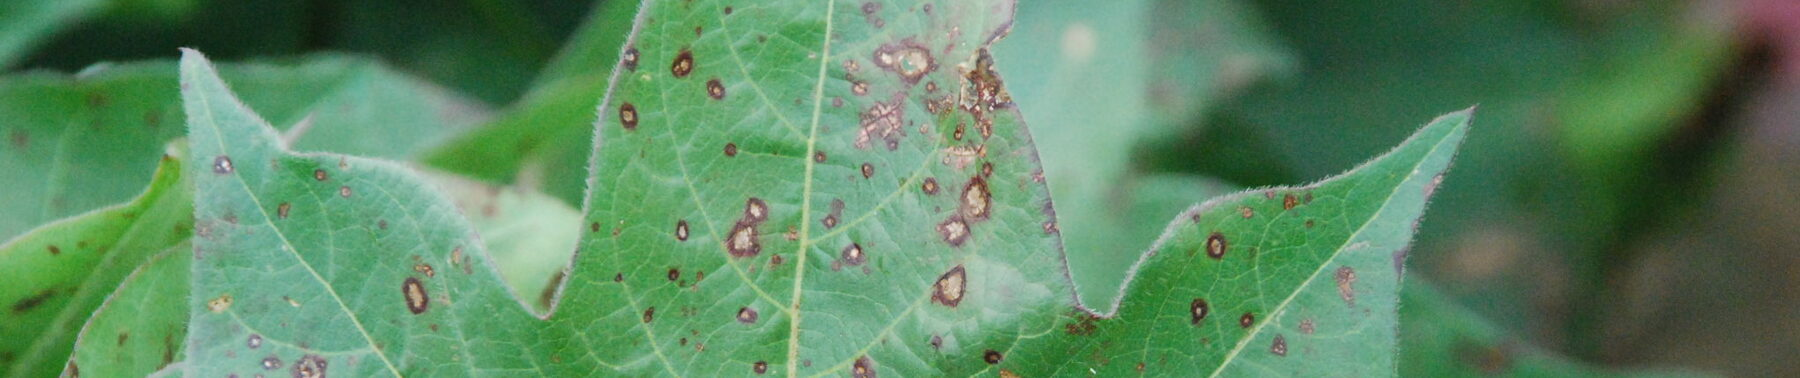

# DataSet Information
***We have 38 classes of plant disease images which contains 70295 images in training set and 17572 in valid set***

***Each class contains average of 1700-1800 number of images to work upon***

***Each image is of size= (256,256,3)***

## Import Used Libraries

In [8]:
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import os
import tensorflow
from tensorflow import keras
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,AveragePooling2D,Dense,Flatten,ZeroPadding2D,BatchNormalization,Activation,Add,Input,Dropout,GlobalAveragePooling2D
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
import warnings
warnings.filterwarnings(action='ignore')

## Loading Data File

In [9]:
data_dir = "../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"

In [10]:
diseases = os.listdir(train_dir)
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))
    
img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
Tomato___Late_blight,1851
Tomato___healthy,1926
Grape___healthy,1692
Orange___Haunglongbing_(Citrus_greening),2010
Soybean___healthy,2022
Squash___Powdery_mildew,1736
Potato___healthy,1824
Corn_(maize)___Northern_Leaf_Blight,1908
Tomato___Early_blight,1920
Tomato___Septoria_leaf_spot,1745


Text(0.5, 1.0, 'Images per each class of plant disease')

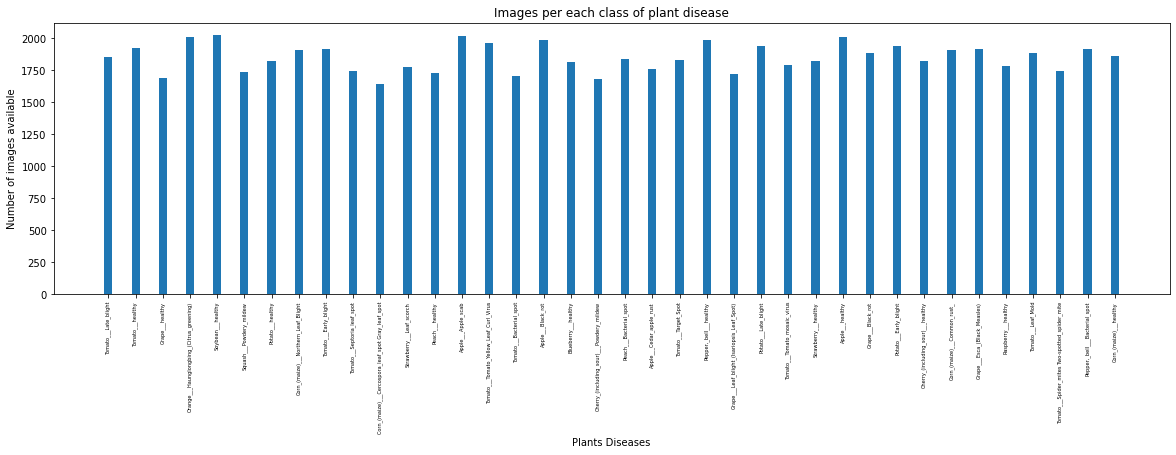

In [11]:
index = [n for n in range(38)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Plants Diseases', fontsize=10)
plt.ylabel('Number of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=5, rotation=90)
plt.title('Images per each class of plant disease')

## Preparing Data For Training

In [12]:
train_datagen= ImageDataGenerator(shear_range=0.2,zoom_range=0.2,horizontal_flip=False,vertical_flip=False,fill_mode='nearest',width_shift_range=0.2,height_shift_range=0.2)
val_datagen=ImageDataGenerator()

train= train_datagen.flow_from_directory(train_dir,batch_size=32,target_size=(230,230),color_mode='rgb',class_mode='categorical',seed=42)

valid=val_datagen.flow_from_directory(valid_dir,batch_size=32,target_size=(230,230),color_mode='rgb',class_mode='categorical')

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [13]:
from tensorflow.keras.applications import ResNet50
base_model_tf=ResNet50(include_top=False,weights='imagenet',input_shape=(230,230,3),classes=38)

2022-11-07 22:47:47.113371: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [14]:
from tensorflow.keras.applications.resnet50 import preprocess_input
base_model_tf.trainable=False
pt=Input(shape=(230,230,3))
func=tensorflow.cast(pt,tensorflow.float32)
x=preprocess_input(func) 
model_resnet=base_model_tf(x,training=False)
model_resnet=GlobalAveragePooling2D()(model_resnet)
model_resnet=Dense(128,activation='relu')(model_resnet)
model_resnet=Dense(38,activation='softmax')(model_resnet)


model_main=Model(inputs=pt,outputs=model_resnet)
model_main.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 230, 230, 3)]     0         
_________________________________________________________________
tf.cast (TFOpLambda)         (None, 230, 230, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 230, 230, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 230, 230, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272

In [15]:
model_main.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model_main.fit(train,validation_data=valid,epochs=1,verbose=1)

2022-11-07 22:47:49.546176: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


2197/2197 [==============================] - 6851s 3s/step - loss: 0.3045 - accuracy: 0.9116 - val_loss: 0.1708 - val_accuracy: 0.9434


In [18]:
model_main.save("model_main.h5")

In [20]:
image_size = 224
target_size = (image_size, image_size)
input_shape = (image_size, image_size, 3)

batch_size = 32
epochs = 25
categories = list(train.class_indices.keys())

In [21]:
import tensorflow as tf
base_model = tf.keras.applications.MobileNet(weights = "imagenet",
                                             include_top = False,
                                             input_shape = input_shape)

base_model.trainable = False

In [22]:
inputs = keras.Input(shape = input_shape)

x = base_model(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(len(categories), 
                          activation="softmax")(x)

model = keras.Model(inputs = inputs, 
                    outputs = x, 
                    name="LeafDisease_MobileNet")

In [23]:
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer = optimizer,
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
              metrics=[keras.metrics.CategoricalAccuracy(), 
                       'accuracy'])

In [ ]:
history = model.fit(train,
                    validation_data=valid,
                    epochs=epochs,
                    steps_per_epoch=150,
                    validation_steps=100,
                   verbose=1)

Epoch 1/25
150/150 [==============================] - 133s 873ms/step - loss: 2.9035 - categorical_accuracy: 0.2231 - accuracy: 0.2231 - val_loss: 2.0384 - val_categorical_accuracy: 0.4531 - val_accuracy: 0.4531
Epoch 2/25
128/150 [========================>.....] - ETA: 13s - loss: 1.9850 - categorical_accuracy: 0.4341 - accuracy: 0.4341

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,loss,c="red",label="Training")
plt.plot(epochs,val_loss,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

epochs = range(len(acc))

fig = plt.figure(figsize=(10,6))
plt.plot(epochs,acc,c="red",label="Training")
plt.plot(epochs,val_acc,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [ ]:
model.save("model.h5")